# N-Ethyl-2-pyrrolidone fit (c1)

In [12]:
%matplotlib widget

import os
import pandas as pd
import numpy as np
import numpy.polynomial as nppoly # for experimental correction factor
from matplotlib import pyplot as plt
import ftmwfitting as fit
import spcattransition as spc

def gauss(x,x0,w):
    return np.exp(-(x-x0)**2/2/w**2)

def lor(x,x0,w):
    return 1./(1.+(x-x0)**2/w**2)

# cat file editor
def load_cat(filename, thresh=1e-3, fmin=26500, fmax=40000):
    spcat_list = spc.parse_cat(filename)
    cat_y = np.asarray([x.int for x in spcat_list if x.freq >= fmin and x.freq <= fmax])
   
    cutoff = thresh*np.max(cat_y) 

    cat_x = np.asarray([x.freq for x in spcat_list if x.freq >= fmin and x.freq <= fmax and x.int >= cutoff])
    cat_y = np.asarray([x.int for x in spcat_list if x.freq >= fmin and x.freq <= fmax and x.int >= cutoff])
    
    cat = np.asarray([x for x in spcat_list if x.freq >= fmin and x.freq <= fmax and x.int >= cutoff])
    
    sim_x = np.linspace(26500, 40000, 500000)
    sim_y = np.zeros_like(sim_x)
    for (x,y) in zip(cat_x,cat_y):
        sim_y = sim_y + y*gauss(sim_x,x,.07)
        
    return cat, cat_x, cat_y, sim_x, sim_y

def assign(lin_file,peak_df,cat,peak_index,cat_index,error=0.050,blend=1.000): # this bit takes the cat file and assigns it to a given experimental peak ID in the assign() function, and prints it to the .lin file
    freq = peak_df.loc[peak_index,'$x_0$'] # Extract the frequency from the peak DataFrame at the given peak index
    transition = cat[cat_index]  # Get the transition data from the catalog at the given catalog index
    
    # Format the upper quantum numbers (uqns) and lower quantum numbers (lqns) 
    uqns = ''.join([f'{str(x): >3}' for x in transition.uqns if x is not None])
    lqns = ''.join([f'{str(x): >3}' for x in transition.lqns if x is not None])
   
    # Open the .lin file in append mode and write the formatted data
    with open(lin_file,'a+') as lin:
        lin.write(f'{uqns}{lqns:<30}{freq:>19.4f}{error:>7.3f}{blend:>11.3e}\n')
        

# Importing experimental data

In [10]:
# No window function
exp_nowind_df = pd.read_csv(r'./Experiment/exp_peaks_nowind.csv')  
exp_nowind_spectrum = pd.read_csv(r'./Experiment/exp_lines_nowind.csv', sep=",", header=None)

x_nowind_ft = exp_nowind_spectrum[0]
y_nowind_ft = exp_nowind_spectrum[1]

# Hamming window function
exp_hamming_df = pd.read_csv(r'./Experiment/exp_peaks_hamming.csv')    
exp_hamming_spectrum = pd.read_csv(r'./Experiment/exp_lines_hamming.csv', sep=",", header=None)

x_hamming_ft = exp_hamming_spectrum[0]
y_hamming_ft = exp_hamming_spectrum[1]

# Correction factor to experimental data
coefs = [0.82781252,   0.09688453,  -1.47473537,   2.09924026,
         8.38133711,  -6.68553143, -18.27020887,   8.07068797,
        17.75970121,  -3.39324528,  -6.58368882]
corr = nppoly.Polynomial(coefs,[26500.,40000.],[-1.,1.])

# Adding info on spur
x_spur = [28800, 29440, 30720, 32960, 34560, 35840, 39040]
y_spur = []
for x in x_spur:
    idx = np.argmin(np.abs(x_nowind_ft-x))
    y_spur.append(y_nowind_ft[idx])

# Loading simulation

In [4]:
# Importing the .lin file -- visualizes assigned lines by reading the frequency from the .lin file, and plots them as vertical dashed lines on the plot
lin_file = "./Simulation/c1/ep.lin"
def mark_assigned(ax,lin_file): 
    with open(lin_file,'r') as lin:
        for l in lin:
            freq = float(l[38:].split()[0])
            ax.axvline(freq,linestyle='dashed',color='#767cb0', alpha=0.3, lw=1)    

# Loading simulation catalogue
cat, cat_x, cat_y, sim_x, sim_y = load_cat('./Simulation/c1/ep.cat')

# Plotting Experiment vs. Simulation

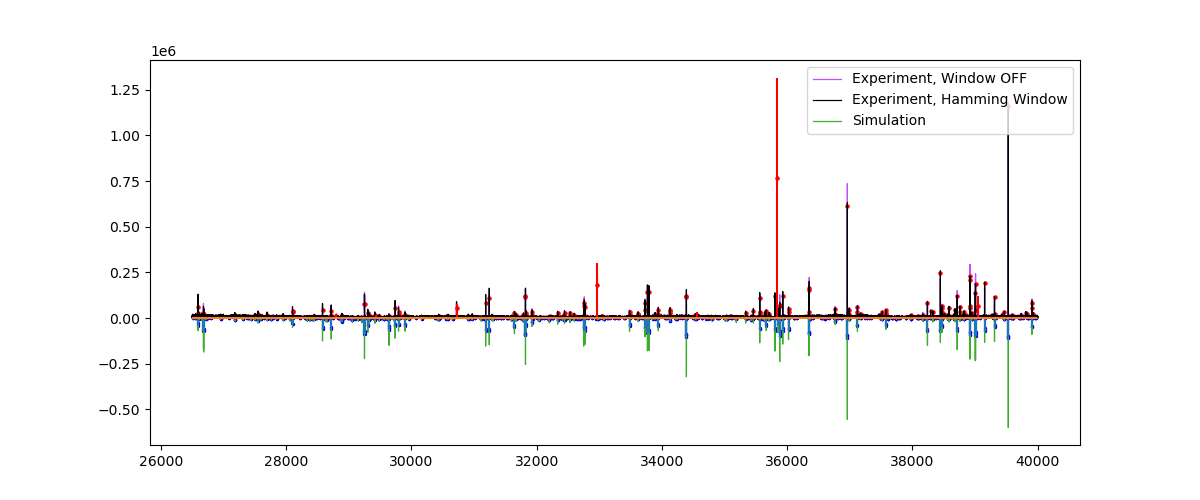

In [11]:
fig,ax = plt.subplots(figsize=(12,5))
sim_scaling = 5e7

ax.plot(x_nowind_ft,0.5*y_nowind_ft/corr(x_nowind_ft), c='#aa00ff', alpha=0.7, lw=0.9, label='Experiment, Window OFF') 
ax.plot(x_hamming_ft,y_hamming_ft/corr(x_hamming_ft), c='black', alpha=1, lw=0.9, label='Experiment, Hamming Window') 

ax.plot(sim_x,-sim_y*sim_scaling,color='#3DAE2B', label='Simulation', lw=0.9)
ax.stem(x_spur,y_spur,linefmt='r-',basefmt=' ',markerfmt=' ')
ax.stem(cat_x,-cat_y*sim_scaling,markerfmt='',basefmt='')

scatter_peak = ax.scatter(exp_hamming_df['$x_0$'],exp_hamming_df.A,color='red',s=5)
scatter_cat = ax.scatter(cat_x,-cat_y*sim_scaling, color ='blue', s=2) 

labels_peak = [f'Peak {i}' for i in range(len(exp_hamming_df))] # Create a list of labels for the peaks
labels_cat = [f'Cat {i}' for i in range(len(cat_y))] # Create a list of labels for the cat_y values

ax.legend(loc=1)
# mark_assigned(ax,lin_file) # toggle this to show assigned lines in the .lin file

plt.show()